# Project: Digital Payment Fraud Detection
## by Olatunde Ashiru
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#description">Dataset Description</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#mlm">Machine Learning Models</a></li>
<li><a href="#prediction">Predictions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The rise of digitization and the increase in online banking, neobanks, and fintech solutions come the looming threat of fraud. These fraudulent activities can vary from false transactions to stolen credit cards. The most common of these fraudulent transactions occur when card or account information gets into the wrong hands. In principle, these sorts of transactions are not hard to spot as they occur in locations, and volumes not readily associated with the original account owner. 


Nevertheless, it can be challenging for companies with millions of transactions and/or customers to pinpoint such them manually or even hard coded rules. However, this can be a perfect  task for a well-trained Machine Learning sysytem

<a id='description'></a>
## Dataset Description

### Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to researchers in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

A synthetic dataset was generated using the simulator called `PaySim` as an approach to such a problem. `PaySim` uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### Content
`PaySim` simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an `African` country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.
[Data Source](https://www.kaggle.com/datasets/ealaxi/paysim1)

### Meaning of Columns
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction.

**newbalanceDest** - new balance recipient after the transaction.

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
## Importing required libraries

import pandas as pd #for Loading the dataset and data preprocessing

#Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Linear Algebra
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


<a id='wrangling'></a>
## Data Wrangling
Assessing the dataset for the number of rows and columns, as well as the data types in each column. Loading the dataset and printing out a few lines. As well as performing operations to inspect the dataset. Finding data types and looking for instances of missing or possibly errant data.

In [5]:
# Downloading the dataset from Kaggle with opendatasets library
import opendatasets as od
 
od.download(
    "https://www.kaggle.com/datasets/ealaxi/paysim1/download?datasetVersionNumber=2")

Skipping, found downloaded files in ".\paysim1" (use force=True to force download)


In [2]:
# reading the CSV file
file =('paysim1/\
PS_20174392719_1491204439457_log.csv')

In [3]:
#Reading the dataset
data = pd.read_csv(file)

In [4]:
# Checking the first five enteries
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Investigating the data types in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Checking whether the dataset has any null values or non
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The dataset does not have any null values. Before moving forward, now, let’s have a look at the type of transaction mentioned in the dataset:

In [7]:
# renaming the 'oldbalanceOrg' to 'oldbalanceOrig'
# so as to be consistent with similar columns like 'nameOrig'
data.rename(columns = {'oldbalanceOrg':'oldbalanceOrig'}, inplace = True)

<a id='eda'></a>
## Exploratory Data Analysis

In [8]:
# Exploring transaction type
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [9]:
# creating data to plot using data from the 'type' variable

transaction_types_class = data["type"].value_counts()
exact_trans = transaction_types_class.index
quantity_trans = transaction_types_class.values

Now I'm going to create an exploded pie chart for similar data using the matplotlib library

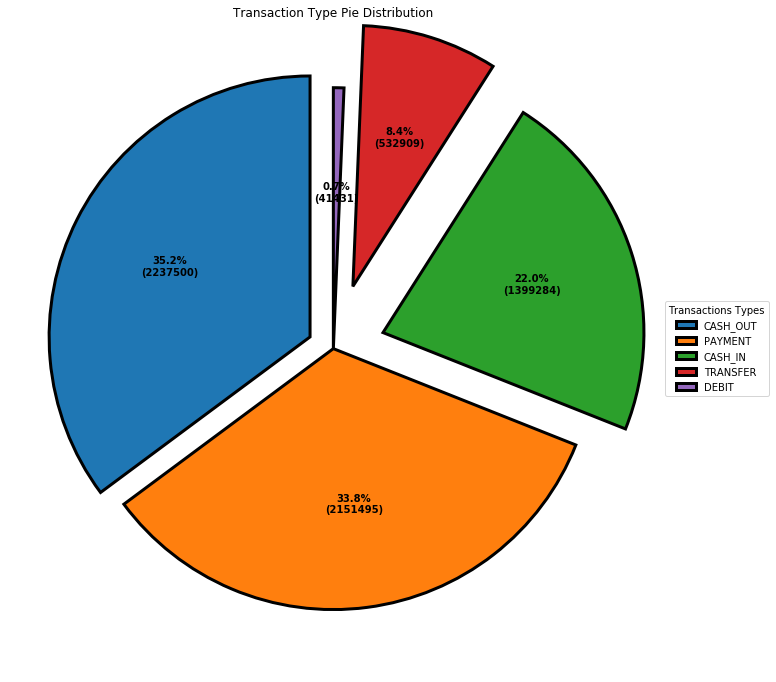

In [10]:
# Plotting an exploded Pie Chart

# Creating explode data
explode = (0.1, 0.0, 0.2, 0.25, 0.0)
 
# Creating
 
# Wedge properties
wp = { 'linewidth' : 3, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvals):
    absolute = int(pct / 100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(18, 12))
wedges, texts, autotexts = ax.pie(quantity_trans,
                                  autopct = lambda pct: func(pct, quantity_trans),
                                  explode = explode,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, exact_trans,
          title ="Transactions Types",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autotexts, size = 10, weight ="bold")

# Adding tite
ax.set_title("Transaction Type Pie Distribution" )
 
# show plot
plt.show();

The above plot is plotted using a similar example found on the [matplotlib documentation page](https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py) with some adjustment

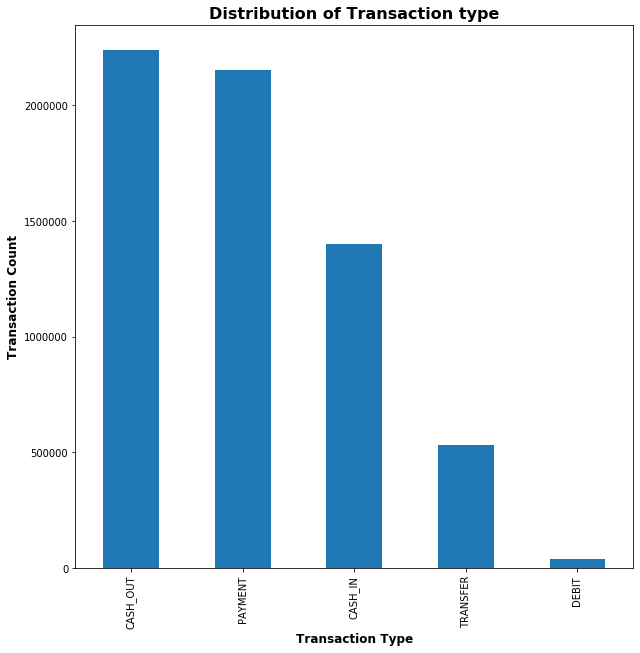

In [11]:
# Bar Plot of the Transaction Type

data.type.value_counts().plot(kind='bar',figsize=(10,10))
plt.title('Distribution of Transaction type',fontsize = 16, weight = "bold")
plt.ylabel('Transaction Count', fontsize = 12, weight = "bold")
plt.xlabel('Transaction Type', fontsize = 12, weight = "bold")
plt.show();

There are more CASH_OUT transactions than any other type of transactions. Now let's check how many fraud cases were identified for each of this transaction type

In [12]:
# Investigating the number of each type of classes in the target variable
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [13]:
# Investigating the number of each type of classes in the `isFlaggedFraud` variable
data['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [14]:
fraud_type = data.groupby(['isFraud'])['type'].value_counts()
fraud_type 

isFraud  type    
0        CASH_OUT    2233384
         PAYMENT     2151495
         CASH_IN     1399284
         TRANSFER     528812
         DEBIT         41432
1        CASH_OUT       4116
         TRANSFER       4097
Name: type, dtype: int64

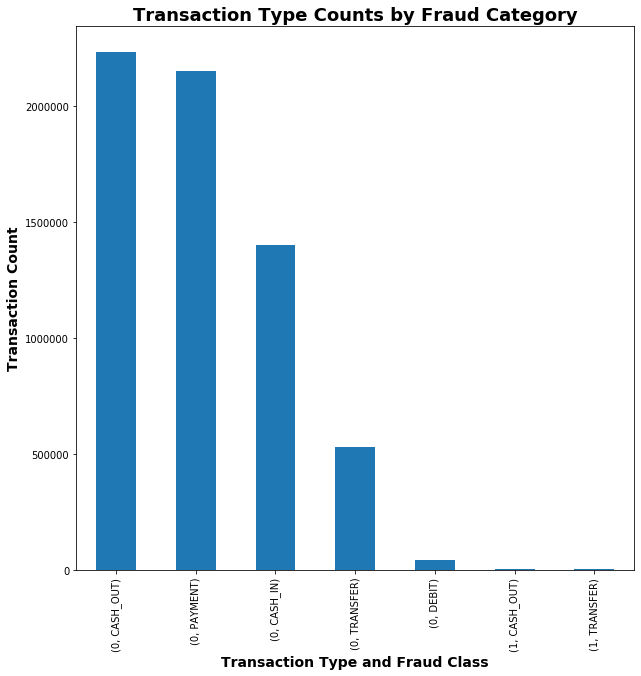

In [15]:
# Plot of Transaction Count By Type and Fraud Class

plt.figure(figsize=(10,10))
fraud_type.plot(kind='bar')
plt.title ('Transaction Type Counts by Fraud Category', fontsize=18, weight = 'bold')
plt.xlabel('Transaction Type and Fraud Class', fontsize=14, weight = 'bold')
plt.ylabel('Transaction Count', fontsize=14, weight = 'bold' )
plt.show();

The fraud cases recorded in the dataset were almost equally shared by the CASH_OUT and TRANSFER transaction type, with both transaction types having 4116 and 4097 fraud cases respectively.

Now let’s have a look at the correlation between the features of the data with the **isFraud column**:

In [16]:
# Checking correlation
data_correlation = data.corr()
data_correlation

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrig,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


From the above table, we can see that there exist non-linear correlation between the `isFraud` variable and other variables, expect in the case of the `oldbalanceorig` and `newbalanceOrig` as well as the `oldbalanceDest` and `newbalanceDest` which is highly understandable.

In [17]:
# Selecting and sorting the "isFraud" column

data_correlation["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrig    0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

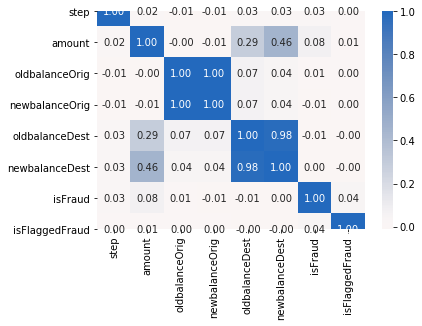

In [18]:
sns.heatmap(data_correlation, cmap = 'vlag_r', annot = True,
          fmt ='.2f', center = 0);

The above correlation table and heatmap shows there's no linear correlation between the preditors and and the target variables. 

Now let’s transform the categorical features into numerical. I also transform the values of the **isFraud** column into `No Fraud` and `Fraud` labels to have a better understanding of the output:

In [22]:
#Transforming categorical features to numerical features

data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<a id='mlm'></a>
## Machine Learning Models

### Fraud Detection Model

In [23]:
# Importing machine learn model
from sklearn.tree import DecisionTreeClassifier

#Need these for selecting the best model
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold

#These will be our main evaluation metric #Evaluation Metrics
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Will use this to "normalize" our data.
from sklearn.preprocessing import normalize

# For normalizing our dataset to common scale
from sklearn.preprocessing import MinMaxScaler

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

When performing Machine Learning model on the dataset, we use variables that are important to train our model. I need to select only important features that can increase the performance of the model. To learn and know more about feature selection techniques, I recommend the following articles:


*    [Introduction to Feature Selection methods with an example (or how to select the right variables?)](https://https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)
*   [The 5 Feature Selection Algorithms every Data Scientist should know](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
*   [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
*   [Feature Selection Techniques in Machine Learning with Python](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

In [24]:
# spliting the dataset into predictors and target by dropping redundant variables

X = data.drop(columns = ['step','nameOrig','nameDest'], axis =1)
y = data['isFraud']

In [25]:
X.head()

,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,2,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,2,11668.14,41554.0,29885.86,0.0,0.0,0,0


### Solving the `imbalance` in the Data set by oversampling the lesser class

In [30]:
# Oversampling the minor class
import imblearn 
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state= 1 ) 

# Fitting the sampling method on the dataset
X_balanced, y_balanced = smote.fit_sample(X, y)

### Chi-Square Features
This is a filter-based method.  In this method, we calculate the chi-square metric between the target and the predictor variables and only select the variables with the maximum chi-squared values.

In [25]:
# Importing the Filter-Based selection methods

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Creating the selector
chi_selector = SelectKBest(chi2, k=5)

# Fitting the selector on the balanced dataset
chi_selector.fit(X_balanced, y_balanced)

SelectKBest(k=5, score_func=<function chi2 at 0x00000244E1D4EA68>)

In [26]:
# Getting the supported features with the `get_support` attribute

chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

5 selected features


In [27]:
chi_feature

['amount',
 'oldbalanceOrig',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

### Recursive Feature Elimination¶
This is a wrapper based method. Wrapper methods consider the selection of a set of features as a search problem.  See example [Implementation](https://machinelearningmastery.com/rfe-feature-selection-in-python/)
<br><br>
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `featureimportances` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

I could use any estimator with the method. In this case, I've decided to use tree-based algorithms such as `DecisionTreeClassifier`, `RandomForestClassifier`, `LGBMClassifier` and the `RFE` observes the `featureimportances_ `attribute of these objects

In [28]:
# Importing the Recursive Feature Elimination method.
from sklearn.feature_selection import RFE

# Calling the RFE with one of the tree based algorithm, in case DecisionTreeClassifier
rfe_selector_dtc = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=5)

# Fitting the RFE on the balanced dataset
rfe_selector_dtc.fit(X_balanced, y_balanced)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=5, step=1, verbose=0)

In [29]:
# Getting the features that are supported to most like predict the outcome correctly

rfe_support_dtc = rfe_selector_dtc.get_support()
rfe_feature_dtc = X.loc[:,rfe_support_dtc].columns.tolist()
print(str(len(rfe_feature_dtc)), 'selected features')

5 selected features


In [30]:
rfe_feature_dtc

['newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

#### Using `RandomForestClassifier()` as an estimator for RFE

In [31]:
# Importing RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Calling the RFE with RandomForestClassifier
rfe_selector_rf = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

# Fitting the RFE on the balanced dataset
rfe_selector_rf.fit(X_balanced, y_balanced)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=5, step=1, verbose=0)

In [32]:
rfe_support_rf = rfe_selector_rf.get_support()
rfe_feature_rf = X.loc[:,rfe_support_rf].columns.tolist()
print(str(len(rfe_feature_rf)), 'selected features')

5 selected features


In [33]:
rfe_feature_rf 

['type', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'isFraud']

#### Using ExtraTreesClassifier() as an estimator for RFE

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
rfe_selector_et = RFE(estimator=ExtraTreesClassifier(), n_features_to_select=5)
rfe_selector_et.fit(X_balanced, y_balanced)

RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=5, step=1, verbose=0)

In [35]:
rfe_support_et = rfe_selector_et.get_support()
rfe_feature_et = X.loc[:,rfe_support_et].columns.tolist()
print(str(len(rfe_feature_et)), 'selected features')

5 selected features


In [36]:
rfe_feature_et 

['type', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'isFraud']

#### Using `LGBMClassifier()` as an estimator for RFE

In [37]:
# Importing LGBMClassifier
from lightgbm import LGBMClassifier

lgb=LGBMClassifier()

rfe_selector_lgb = RFE(estimator = lgb, n_features_to_select=5)

# Fitting the RFE method on the balanced dataset
rfe_selector_lgb.fit(X_balanced, y_balanced)

RFE(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
  n_features_to_select=5, step=1, verbose=0)

In [38]:
# Getting the features that are supported to most like predict the outcome correctly


rfe_support_lgb = rfe_selector_lgb.get_support()
rfe_feature_lgb = X.loc[:,rfe_support_lgb].columns.tolist()
print(str(len(rfe_feature_lgb)), 'selected features')

5 selected features


In [39]:
rfe_feature_lgb

['type', 'amount', 'oldbalanceOrig', 'oldbalanceDest', 'isFraud']

Now I'll explore the Embedded method with the tree based algorithms we used above to select the best features.

### Embedded Method: SelectFromModel
This is an Embedded method. Embedded methods use algorithms that have built-in feature selection methods. We are starting with `RandomForest` to select features based on feature importance.<br><br>
We calculated feature importance using node impurities in each decision tree.<br><br> 
**NOTE**: 
In `Random forest`, the final `feature importance` is the average of all decision tree feature importance.

#### Using `DecisionTree` for the Embedded method

In [40]:
# Importing the SelectFromModel
from sklearn.feature_selection import SelectFromModel

# Using Decision Tree for the Embedded method

embeded_dtc_selector = SelectFromModel(DecisionTreeClassifier())

# Fitting the Embedded Method with DecisionTree 
# as a based estimator on the balanced dataset

embeded_dtc_selector.fit(X_balanced, y_balanced)

SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
        norm_order=1, prefit=False, threshold=None)

In [41]:
# Getting the supported features with DecisonTrees
# When used as a based algorithm for the Embedded method

embeded_dtc_support = embeded_dtc_selector.get_support()
embeded_dtc_feature = X.loc[:,embeded_dtc_support].columns.tolist()
print(str(len(embeded_dtc_feature)), 'selected features')

1 selected features


In [42]:
embeded_dtc_feature

['isFraud']

#### Using `RandomForest` for the Embedded method

In [43]:

# Calling the Embedded method on the tree based algorithm, taking RandomForest
embeded_rf_selector = SelectFromModel(RandomForestClassifier())


# Fitting the Embedded method on the balanced dataset
embeded_rf_selector.fit(X_balanced, y_balanced)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [44]:
# Getting the features that are supported to most like predict the outcome correctly


embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

1 selected features


In [45]:
embeded_rf_feature

['isFraud']

#### Using `ExtraTreesClassifier` as base alogrithm in the embedded method

In [46]:
# Using Extra Tree as base alogrithm in the embedded method

embeded_et_selector = SelectFromModel(ExtraTreesClassifier())
embeded_et_selector.fit(X_balanced, y_balanced)

SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [47]:
embeded_et_support = embeded_et_selector.get_support()
embeded_et_feature = X.loc[:,embeded_et_support].columns.tolist()
print(str(len(embeded_et_feature)), 'selected features')

1 selected features


In [48]:

embeded_et_feature

['isFraud']

I will also try `LightGBM`. We could also have used an `XGBoost` object as long it has a featureimportances attribute.

#### Using `LightGBMClassifier` as base alogrithm in the embedded method

In [49]:
# Using LightGBM Classfier

lgb=LGBMClassifier()

embeded_lgb_selector = SelectFromModel(lgb)
embeded_lgb_selector.fit(X_balanced, y_balanced)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        norm_order=1, prefit=False, threshold=None)

In [50]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

4 selected features


In [51]:
embeded_lgb_feature

['type', 'amount', 'oldbalanceOrig', 'isFraud']

### Putting Everything together

In [52]:
pd.set_option('display.max_rows', None)

# putting all selection together
feature_name = list(X.columns)
feature_selection_df = pd.DataFrame({'Feature':feature_name,'Chi-2':chi_support, 'RFE_DTC':rfe_support_dtc, 
                                     'RFE_RF':rfe_support_rf, 'RFE_ETC':rfe_support_et,'RFE_LGB':rfe_support_lgb,
                                     'DecisonTree': embeded_dtc_support,'Random Forest':embeded_rf_support,
                                     'ExtraTrees':embeded_et_support,'LightGBM':embeded_lgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(6)

,Feature,Chi-2,RFE_DTC,RFE_RF,RFE_ETC,RFE_LGB,DecisonTree,Random Forest,ExtraTrees,LightGBM,Total
1,isFraud,False,True,True,True,True,True,True,True,True,8
2,oldbalanceOrig,True,False,True,True,True,True,True,False,True,7
3,amount,True,False,True,True,True,False,False,False,True,5
4,type,False,False,True,True,True,False,False,False,True,4
5,newbalanceOrig,True,True,True,True,False,False,False,False,False,4
6,oldbalanceDest,True,True,False,False,True,False,False,False,False,3


Looking at the above table, it seems the features that are most likely to predict our target class are `oldbalanceOrig`,  `amount`, `type` , `newbalanceOrig`,  and `oldbalanceDest`. Would these features be enough to predict the Target class correctly? I will check further with the `Feature Importance` attribute of `ExtraTreesClassifier`<br><br>
**Note:** `isFraud` variable is not listed since it is the variable we're trying to predict

### Feature Importance 
Using `ExtraTreesClassifier()` for feature importance on a classification problem

In [52]:
# Extratree for feature importance on a classification problem
# define the model
model = ExtraTreesClassifier()
# fit the model
model.fit(X_balanced, y_balanced)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Checking the most important features using the ExtraTreesClassifier Model

In [53]:
#Checking the most important features using the optimal ExtraTreeClassifier Model
feature_importance = model.feature_importances_

In [54]:
feature_importance_best = np.std([tree.feature_importances_ for tree in 
                                        model.estimators_],
                                        axis = 0)

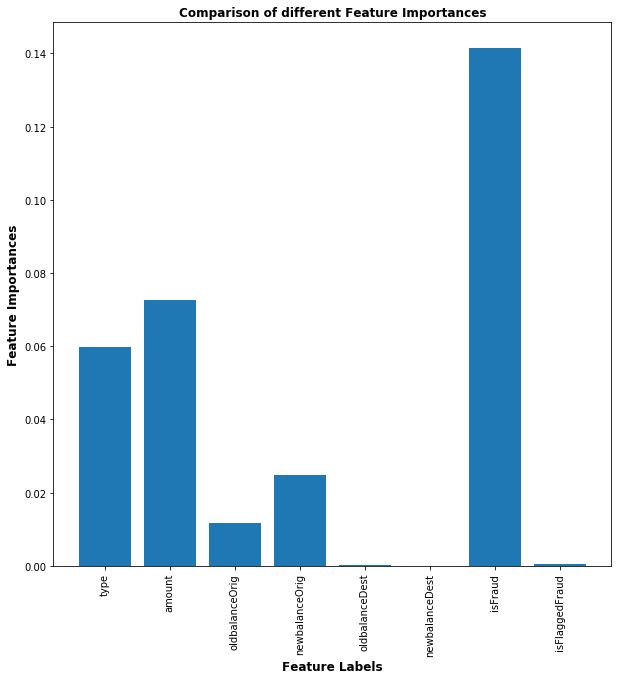

In [55]:
# Bar Plot showing the height of different features

plt.figure(figsize=(10,10))
plt.bar(X.columns, feature_importance_best)
plt.xlabel('Feature Labels', fontsize = 12, weight = "bold")
plt.ylabel('Feature Importances', fontsize = 12, weight = "bold")
plt.xticks(rotation = 90)
plt.title('Comparison of different Feature Importances', fontsize = 12, weight = "bold")
plt.show();

From the above graph, the best features are `type`, `amount`, `oldbalanceOrig`, `newbalanceOrig`,  and the target variable, `isFraud`. These are the features we're going to train our Machine Learning model one.

In [56]:
# Putting X_balanced back into a dataframe
X_data = pd.DataFrame(X_balanced, columns=X.columns)
X_data.head()

,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2.0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0
1,2.0,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0
2,4.0,181.00,181.0,0.00,0.0,0.0,1.0,0.0
3,1.0,181.00,181.0,0.00,21182.0,0.0,1.0,0.0
4,2.0,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0


In [57]:
# splitting the data on the best features
# to predictors and target variable
predictors = X_data[["type", "amount", "oldbalanceOrig", "newbalanceOrig"]]
target = y_balanced

#### Training the fraud detection model: 
We will split our dataset (Preditors (X) and Target/Label (Y)) into training and test data by using train_test_split() function from sklearn. The training set will be 80% while the test set will be 20%. The random_state that is set to 42.

In [58]:
# training a machine learning model
Xtrain, Xtest, ytrain, ytest = train_test_split(predictors, target, test_size=0.20, random_state=42)

In [59]:
model = DecisionTreeClassifier()

In [60]:
model.fit(Xtrain, ytrain)
print(model.score(Xtest, ytest))

0.9970878480802499


The accuracy of the model is approximately 1.0

Now let’s classify whether a transaction is a fraud or not by feeding about a transaction into the model:

<a id='prediction'></a>
## Predictions

In [61]:
# Features for new observations
features = ['type', 'amount', 'oldbalanceOrig', 'newbalanceOrig']

# Defining new observations
observation = np.array([[4, 9000.60, 9000.60, 0.0]])

# Predicting which class the new observation belongs to
print(model.predict(observation))

[1]


#### It is classified as been fraud

#### Evaluation

In [62]:
# Recall Score
pred = model.predict(Xtest)
recall = recall_score(ytest, pred, pos_label= 1) 
print( 'Recall: {}' .format(recall))

Recall: 0.9971831562183794


In [63]:
# Precision score
precision = precision_score(ytest, pred, pos_label= 1) 
print( 'Precision: {}' .format(precision))

Precision: 0.996993316383043


In [64]:
# F1 Score
f1 = f1_score(ytest, pred, pos_label= 1) 
print( 'F1_score: {}' .format(f1))

F1_score: 0.9970882272646094


The above metric scores indicate that we might have a good model